In [40]:
# Deep Learning Fundamentals: MNIST Case Study
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd

### Data Collection

In [41]:
import requests

# URLs of the files
data_train_features_url = 'https://www.raphaelcousin.com/modules/module7/exercise/module7_exercise_train_features.csv'
data_train_labels_url = 'https://www.raphaelcousin.com/modules/module7/exercise/module7_exercise_train_labels.csv'
data_test_features_url = 'https://www.raphaelcousin.com/modules/module7/exercise/module7_exercise_test_features.csv'

# Function to download a file
def download_file(url, file_name):
    response = requests.get(url)
    response.raise_for_status()  # Ensure we notice bad responses
    with open(file_name, 'wb') as file:
        file.write(response.content)
    print(f'Downloaded {file_name} from {url}')

# Downloading the files
download_file(data_train_features_url, 'module7_exercise_train_features.csv')
download_file(data_train_labels_url, 'module7_exercise_train_labels.csv')
download_file(data_test_features_url, 'module7_exercise_test_features.csv')

Downloaded module7_exercise_train_features.csv from https://www.raphaelcousin.com/modules/module7/exercise/module7_exercise_train_features.csv
Downloaded module7_exercise_train_labels.csv from https://www.raphaelcousin.com/modules/module7/exercise/module7_exercise_train_labels.csv
Downloaded module7_exercise_test_features.csv from https://www.raphaelcousin.com/modules/module7/exercise/module7_exercise_test_features.csv


In [42]:
X = pd.read_csv('module7_exercise_train_features.csv').values
y = pd.read_csv('module7_exercise_train_labels.csv').values.ravel()

### Data Analysis

In [43]:
X.shape

(60000, 784)

In [44]:
y.shape

(60000,)

In [45]:
def plot_mnist_digits(X, y, num_examples=5, figsize=(15, 3)):
    # Create figure
    fig, axes = plt.subplots(1, num_examples, figsize=figsize)

    # Ensure axes is always a numpy array
    if num_examples == 1:
        axes = np.array([axes])

    # Plot each example
    for i in range(num_examples):
        # Reshape the flattened image back to 28x28
        img = X[i].reshape(28, 28)

        # Plot
        axes[i].imshow(img, cmap='gray')
        axes[i].set_title(f'Label: {y[i]}')
        axes[i].axis('off')

    plt.tight_layout()
    return fig

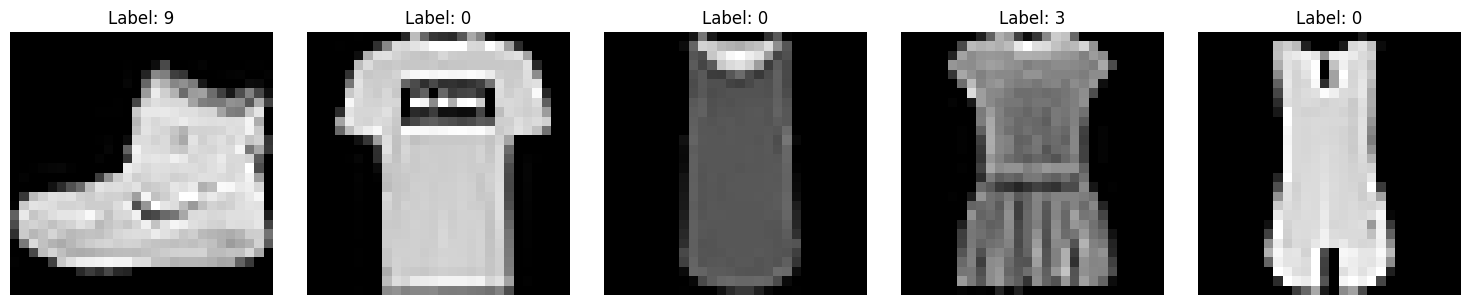

In [46]:
# Plot some examples
fig = plot_mnist_digits(X, y, num_examples=5)
plt.show()

### Data Preprocessing
Scale, split the data and create dataLoaders

In [47]:
from torch.utils.data import TensorDataset, Dataset, DataLoader, random_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [48]:
def preprocess_data(X, y, batch_size=32, train_size=0.7, val_size=0.15, random_state=42):
    # Scale features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Split data into train+val and test
    test_size = 1 - train_size - val_size
    X_trainval, X_test, y_trainval, y_test = train_test_split(
        X_scaled, y, test_size=test_size,
        random_state=random_state, stratify=y
    )

    # Split train+val into train and val
    X_train, X_val, y_train, y_val = train_test_split(
        X_trainval, y_trainval,
        test_size=val_size/(train_size + val_size),
        random_state=random_state, stratify=y_trainval
    )

    # Convert to tensors and create dataloaders
    loaders = {
        'train': DataLoader(
            TensorDataset(torch.FloatTensor(X_train), torch.LongTensor(y_train)),
            batch_size=batch_size, shuffle=True
        ),
        'val': DataLoader(
            TensorDataset(torch.FloatTensor(X_val), torch.LongTensor(y_val)),
            batch_size=batch_size
        ),
        'test': DataLoader(
            TensorDataset(torch.FloatTensor(X_test), torch.LongTensor(y_test)),
            batch_size=batch_size
        )
    }

    return loaders['train'], loaders['val'], loaders['test']

In [49]:
train_loader, val_loader, test_loader = preprocess_data(X, y)

### Model
Create a simple model with right input output and define criterion and criterion/loss

In [50]:

from torch.optim.lr_scheduler import ReduceLROnPlateau


In [51]:
def create_model(device):
    model = dropout_rate = 0.2
    model = nn.Sequential(
                # First hidden layer
                nn.Linear(784, 512),
                nn.ReLU(),
                nn.BatchNorm1d(512),
                nn.Dropout(dropout_rate),

                # Second hidden layer
                nn.Linear(512, 256),
                nn.ReLU(),
                nn.BatchNorm1d(256),
                nn.Dropout(dropout_rate),

                # Third hidden layer
                nn.Linear(256, 128),
                nn.ReLU(),
                nn.BatchNorm1d(128),
                nn.Dropout(dropout_rate),

                # Output layer
                nn.Linear(128, 10)
            ).to(device)
    criterion = nn.CrossEntropyLoss().to(device)

    # Define optimizer (with reasonable defaults)
    optimizer = torch.optim.Adam(
        model.parameters(),
        lr=0.01,
        betas=(0.9, 0.999),
        eps=1e-08,
        weight_decay=0.0001
    )

    scheduler = ReduceLROnPlateau(
        optimizer,
        mode='min',
        factor=0.1,
        patience=5,
        min_lr=1e-6
    )

    return model, criterion, optimizer, scheduler

### Train
Create a loop to train your model

In [52]:
from collections import defaultdict
from time import time

In [53]:
class EarlyStopping:
    def __init__(self, patience=7, min_delta=0, path='checkpoint.pt'):
        self.patience = patience
        self.min_delta = min_delta
        self.path = path
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.val_loss_min = np.inf

    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.save_checkpoint(val_loss, model)
        elif val_loss > self.best_loss + self.min_delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}). Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [54]:
def train_epoch(model, loader, criterion, optimizer, device, is_training=True):
    """Run one epoch of training or validation."""
    model.train() if is_training else model.eval()
    total_loss = 0.0
    correct = 0
    total = 0

    context = torch.enable_grad() if is_training else torch.no_grad()
    with context:
        for data, target in loader:
            data, target = data.to(device), target.to(device)

            if is_training:
                optimizer.zero_grad()

            output = model(data)
            loss = criterion(output, target)

            if is_training:
                loss.backward()
                optimizer.step()

            total_loss += loss.item()
            _, predicted = output.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()

    avg_loss = total_loss / len(loader)
    accuracy = 100. * correct / total
    return avg_loss, accuracy

In [55]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, device, num_epochs=100, patience=7, checkpoint_path='best_model.pt'):
    early_stopping = EarlyStopping(patience=patience, path=checkpoint_path)
    history = defaultdict(list)
    best_acc = 0.0
    start_time = time()
    print("Training started...")
    for epoch in range(num_epochs):
        epoch_start = time()

        # Training phase
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device, is_training=True)

        # Validation phase
        val_loss, val_acc = train_epoch(model, val_loader, criterion, optimizer, device, is_training=False)
        scheduler.step(val_loss)
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['lr'].append(optimizer.param_groups[0]['lr'])

        # Print epoch results
        print(f"\nEpoch {epoch+1}/{num_epochs} - Time: {time() - epoch_start:.2f}s")
        print(f"Train Loss: {train_loss:.4f} - Train Acc: {train_acc:.2f}%")
        print(f"Val Loss: {val_loss:.4f} - Val Acc: {val_acc:.2f}%")
        print(f"Learning Rate: {optimizer.param_groups[0]['lr']:.6f}")
        print("-" * 60)

        early_stopping(val_loss, model)
        if early_stopping.early_stop:
            print("Early stopping triggered")
            break

        # Save best model
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_loss': train_loss,
                'val_loss': val_loss,
                'train_acc': train_acc,
                'val_acc': val_acc,
            }, 'best_acc_model.pt')

    total_time = time() - start_time
    print(f"\nTraining completed in {total_time:.2f} seconds")
    print(f"Best validation accuracy: {best_acc:.2f}%")

    return history

In [56]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create model and training components
model, criterion, optimizer, scheduler = create_model(device)

test_loss, test_acc = train_epoch(
    model, test_loader, criterion, optimizer, device, is_training=False
)
print(f"Test Loss: {test_loss:.4f} - Test Acc: {test_acc:.2f}%")

# Train the model
history = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    scheduler=scheduler,
    num_epochs=50,
    patience=7,
    checkpoint_path='best_model.pt'
)

Test Loss: 2.3050 - Test Acc: 13.38%
Training started...

Epoch 1/50 - Time: 4.78s
Train Loss: 0.6306 - Train Acc: 77.72%
Val Loss: 0.5063 - Val Acc: 81.36%
Learning Rate: 0.010000
------------------------------------------------------------
Validation loss decreased (inf --> 0.506284). Saving model ...

Epoch 2/50 - Time: 5.29s
Train Loss: 0.5658 - Train Acc: 80.28%
Val Loss: 0.5101 - Val Acc: 82.08%
Learning Rate: 0.010000
------------------------------------------------------------
EarlyStopping counter: 1 out of 7

Epoch 3/50 - Time: 4.56s
Train Loss: 0.5518 - Train Acc: 80.76%
Val Loss: 0.4778 - Val Acc: 82.88%
Learning Rate: 0.010000
------------------------------------------------------------
Validation loss decreased (0.506284 --> 0.477848). Saving model ...

Epoch 4/50 - Time: 4.33s
Train Loss: 0.5401 - Train Acc: 81.17%
Val Loss: 0.4935 - Val Acc: 81.99%
Learning Rate: 0.010000
------------------------------------------------------------
EarlyStopping counter: 1 out of 7

Epo

In [57]:
def plot_training_history(history):
    """
    Plot training history

    Parameters:
    -----------
    history : dict
        Training history containing metrics
    """
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 10))

    # Plot loss
    ax1.plot(history['train_loss'], label='Train Loss')
    ax1.plot(history['val_loss'], label='Val Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.legend()
    ax1.grid(True)

    # Plot accuracy
    ax2.plot(history['train_acc'], label='Train Acc')
    ax2.plot(history['val_acc'], label='Val Acc')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.set_title('Training and Validation Accuracy')
    ax2.legend()
    ax2.grid(True)

     # Plot learning rate
    ax3.plot(history['lr'])
    ax3.set_xlabel('Epoch')
    ax3.set_ylabel('Learning Rate')
    ax3.set_title('Learning Rate over Time')
    ax3.set_yscale('log')
    ax3.grid(True)

    # Plot loss vs accuracy
    ax4.scatter(history['train_loss'], history['train_acc'], label='Train')
    ax4.scatter(history['val_loss'], history['val_acc'], label='Val')
    ax4.set_xlabel('Loss')
    ax4.set_ylabel('Accuracy (%)')
    ax4.set_title('Loss vs Accuracy')
    ax4.legend()
    ax4.grid(True)

    plt.tight_layout()
    return fig

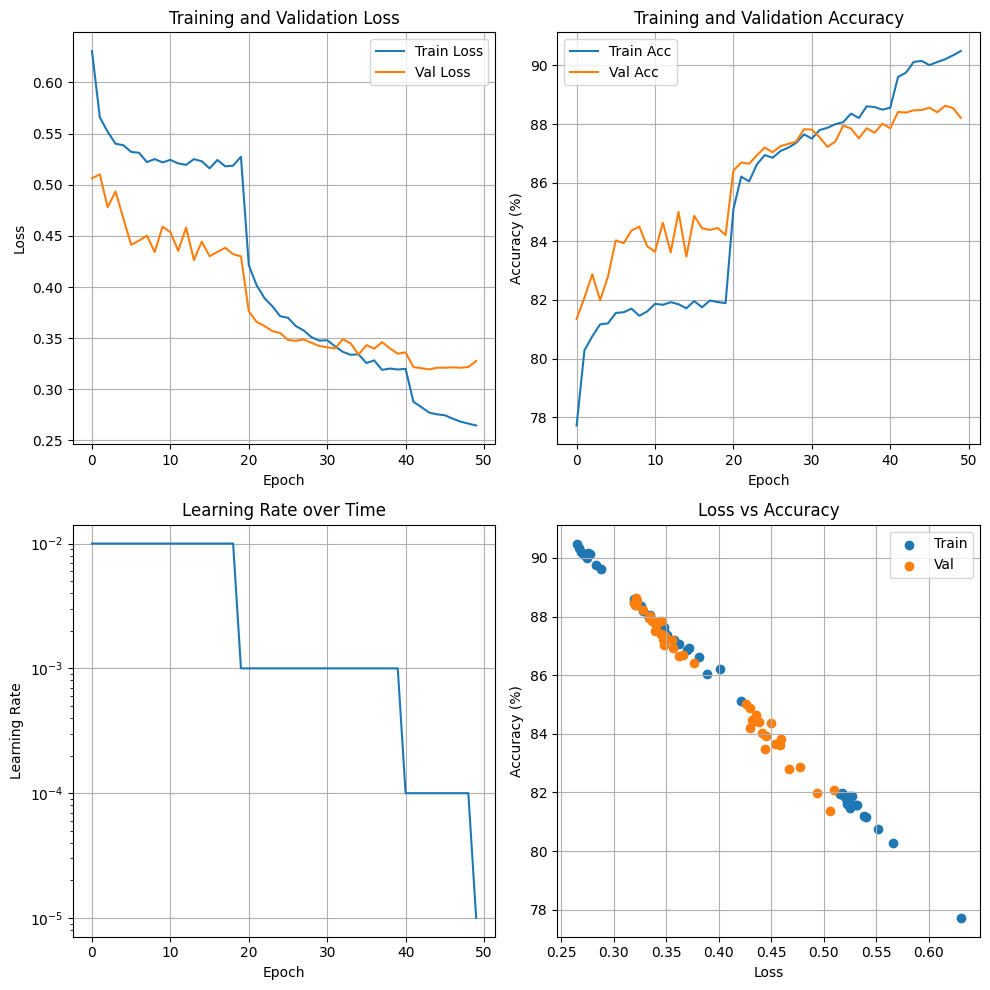

In [58]:
# Plot training history
plot_training_history(history)
plt.show()

### Generating Submission File

In [59]:
X_test = pd.read_csv('module7_exercise_test_features.csv')
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)

In [60]:
model.to(device)
X_test_tensor = X_test_tensor.to(device)

model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    predictions = model(X_test_tensor)

In [61]:
_, predicted_labels = torch.max(predictions, dim=1)

In [62]:
submission = pd.DataFrame({
    'index': X_test.index,
    'label': predicted_labels.cpu().numpy()
})

submission.to_csv('submission.csv', index=False, sep=',')
submission.head()

,index,label
0,0,9
1,1,2
2,2,1
3,3,1
4,4,6
